<a href="https://colab.research.google.com/github/brunafrade/landmarksdetection/blob/master/landmarks_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detector de landmarks utilizando Redes Neurais Convolucionais no  Keras
Por motivos de complexidade de treino vamos limitar o nosso modelo para detectar somente olhos, nariz e boca.
O tutorial original e o dataset foram retirados do <a href="https://www.kaggle.com/richardarendsen/face-landmarks-with-cnn/data?select=face_images.npz">Kaggle </a>.

In [1]:
# caso queira utilizar um ambiente confugurado no docker segue o link da imagem: 
# https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 

import os
print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

['.config', 'sample_data']


In [ ]:
from google.colab import files
uploaded = files.upload()
import io
# Dataset is now stored in a Pandas Dataframe

Saving face_images.npz to face_images.npz


In [9]:
# load the dataset
Pface = np.moveaxis(np.load('face_images.npz')['face_images'],-1,0)
LMs = pd.read_csv('facial_keypoints.csv')

LMpos=LMs.columns.tolist()
print(LMs.isnull().sum())

FileNotFoundError: ignored

Selecionarei apenas as coordenadas x e y do centro dos olhos, ponta do nariz e centro da boca, porque esses valores estão em maior quantidade no dataset. Isso dá 7000 imagens e X e Y são ajustados para a compatibilidade com Keras. Y é normalizado entre 0 e 1.

In [ ]:
iselect=np.nonzero(LMs.left_eye_center_x.notna() & LMs.right_eye_center_x.notna() &
         LMs.nose_tip_x.notna() & LMs.mouth_center_bottom_lip_x.notna())[0]

Spic=Pface.shape[1]
m=iselect.shape[0]
X=np.zeros((m,Spic,Spic,1))
Y=np.zeros((m,8))

X[:,:,:,0]=Pface[iselect,:,:]/255.0
Y[:,0]=LMs.left_eye_center_x[iselect]/Spic
Y[:,1]=LMs.left_eye_center_y[iselect]/Spic
Y[:,2]=LMs.right_eye_center_x[iselect]/Spic
Y[:,3]=LMs.right_eye_center_y[iselect]/Spic
Y[:,4]=LMs.nose_tip_x[iselect]/Spic
Y[:,5]=LMs.nose_tip_y[iselect]/Spic
Y[:,6]=LMs.mouth_center_bottom_lip_x[iselect]/Spic
Y[:,7]=LMs.mouth_center_bottom_lip_y[iselect]/Spic

print('# selected images = %d' %(m))

# selected images = 7000



Bad key "nbagg.transparent" on line 426 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
/home/polsecai/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution
In /home/polseca

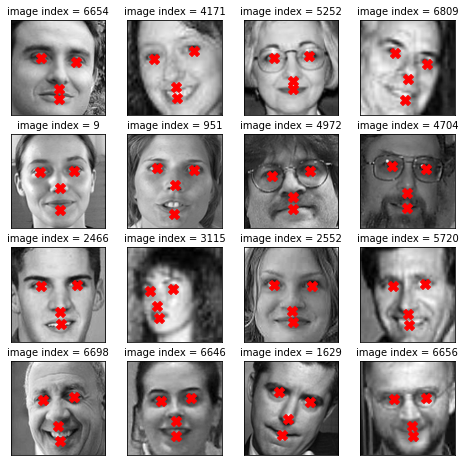

In [ ]:
import matplotlib.pyplot as plt

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Y.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X[irand[n],:,:,0], cmap='gray')
        ax[row,col].scatter(Y[irand[n],0::2]*Spic,Y[irand[n],1::2]*Spic,marker='X',c='r',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1


In [5]:
# Separação do dataset de treino e teste
from sklearn.model_selection import train_test_split

random_seed=21
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

NameError: ignored

O modelo utilizado é uma CNN simples com poucas camadas. como nosso problema é uma regressão, então utilizamos uma sigmoid na ultima camada para fazer a predição dos valores de coordenadas dos nossos landmarks entre 0 e 1. Observe também que a saída do nosso modelo é 8, pois estamos querendo fazer a predição de 4 coordenadas (4 valores da coordenada x e 4 valores para y)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation='tanh', input_shape=(Spic, Spic, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data = (Xtest, Ytest), verbose = 1)

NameError: ignored

In [ ]:
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Ytest.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(Xtest[irand[n],:,:,0], cmap='gray')
        ax[row,col].scatter(Ytest[irand[n],0::2]*Spic,Ytest[irand[n],1::2]*Spic,marker='X',c='r',s=100)
        ax[row,col].scatter(Ytest_pred[irand[n],0::2]*Spic,Ytest_pred[irand[n],1::2]*Spic,marker='+',c='b',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1
plt.suptitle('x: Manual; +: CNN', fontsize=16)

Not bad for a first try. Lots of improvements possible.